In [1]:
from preprocessing import (
    preprocess_kjv,
    get_word_types_with_tf_idf,
    get_gospel_top_70_words_dictionary,
)
from extract_relations import (
    get_directed_relations,
    order_directed_relations,
)
from ontology_algorithm import (
    construct_ontology_hierarchy,
    print_hierarchy_tree_from_ontology,
    draw_hierarchy_tree_from_ontology,
)
from topic_modeling import (
    kmeans_tfidf_clustering,
    filter_topic_modeling_key_terms,
)
import re

## Preprocessing

We will preprocess words from the theology reconsidered text using tf-idf and extract the top n words.

In [2]:
theology_reconsidered_path = "/Users/zebo/Documents/Freelancing/upwork/Peter_J_Worth_Jr/NLP/hierarchical_clustering/data/theology_reconsidered.txt"

with open(theology_reconsidered_path, "r") as f:
    theology_reconsidered = f.read()

def split_into_chapters(input_filename, verbose=False):
    """Split the input file into chapters."""
    titles = []
    chapters = []
    # Open the input file and read its contents
    with open(input_filename, 'r', encoding='utf-8') as input_file:
        contents = input_file.read()

    # Split the contents into chunks based on the separator criteria
    chunks = contents.split('\n\n\n\n')             # empty lines in the text

    ch_cnt = 0

    # Create an output file for each chunk
    for i, chunk in enumerate(chunks):
        # Skip empty chunks
        if not chunk.strip():
            continue

        # Extract the title and content from the chunk
        lines = chunk.strip().split('\n')
        title = lines[0]
        content = '\n'.join(lines[1:])

        if verbose:
            print("processing CH" + str(ch_cnt) + ": " + title + "...")

        # Create the output file
        chapters.append(content)
        titles.append(title)

        ch_cnt += 1
    return titles, chapters

titles, chapters = split_into_chapters(theology_reconsidered_path)

chapters[0]

# Should I remove the word Figure?

# Remove \n from the chapters.
chapters = [chapter.replace("\n", "") for chapter in chapters]
# Remove \t from the chapters.
chapters = [chapter.replace("\t", " ") for chapter in chapters]


# import re

# Separate the chapters into sentences.
sentences_per_chapter_prep = [re.split("\.  ", chapter) for chapter in chapters]
sentences_per_chapter_prep = [[sentence + "." for sentence in chapter] for chapter in sentences_per_chapter_prep]

sentences_per_chapter = []
for chapter_prep in sentences_per_chapter_prep:
    chapter = []
    for sentence in chapter_prep:
        chapter.extend(re.split("(?<!i.e|etc|e.g|iii)\. ", sentence))
    sentences_per_chapter.append(chapter)

#sentences_per_chapter[0]
for title_index, title in enumerate(titles):
    print(title_index, title)

0 Introduction
1 Prologue: Mythos and Mysticism in Antiquity
2 A Brief History of the Mystical Arts: Beyond Yoga
3 Meditation as a Mystical Art: A Bridge Through Time 
4 Overarching Themes: The Laurasian Hypothesis and a New Metaphysics
5 Setting the Stage: A Brief of History of Modern Man
6 Part I: On Creation Mythos (Cosmogony)
7 From Language to Writing: The Dawn of History
8 The Ancient Hebrews: The Tanakh, Torah and Five Books of Moses
9 Ancient Egyptian Mythos: The Weighing of the Heart, Ra and Ma'at
10 The Enûma Eliš: Sumer- Babylonian Creation Mythos
11 Ancient Persian Theology: Zarathustra and the Avesta
12 Classic Hellenic Theogony: Chaos, Chronos and Eros
13 Orphic Theogony: Thanes and the Great Cosmic Egg
14 Vedic Cosmogony: Skepticism, Puruṣa and Hiraṇyagarbha 
15 Ancient Chinese Theology: Shàngdì, Pángǔ, Tiān and the Dao
16 Roman Cosmogony: The Metamorphoses of Ovid
17 Eurasian Mythos: Establishing the Laurasian Hypothesis 
18 Part II: On Ancient Philosophy (Logos)
19 Fro

In [3]:
# Remove chapters, titles and sentences if the title starts with "Part ".
title_indices_to_remove = [title_index for title_index, title in enumerate(titles) if title.startswith("Part ")]

titles = [title for title_index, title in enumerate(titles) if title_index not in title_indices_to_remove]
sentences_per_chapter = [chapter for chapter_index, chapter in enumerate(sentences_per_chapter) if chapter_index not in title_indices_to_remove]
chapters = [chapter for chapter_index, chapter in enumerate(chapters) if chapter_index not in title_indices_to_remove]

## Perform topic modeling

In [4]:
NUM_TOPICS = 8
clusters, key_terms_per_cluster = kmeans_tfidf_clustering(
    chapters=chapters,
    num_topics=NUM_TOPICS,
)

CLUSTER #1
Cluster Chapters: [1, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 28, 30]
Key Features: ['ancient', 'tradition', 'creation', 'gods', 'mythos', 'also', 'well', 'one', 'greek', 'philosophical', 'first', 'egyptian', 'bce', 'earth', 'theogony', 'antiquity', 'egypt', 'god', 'writing', 'orpheus', 'universe', 'hebrew', 'orphic', 'torah', 'great', 'hellenic', 'systems', 'written', 'order', 'hesiod', 'empire', 'rituals', 'world', 'narrative', 'see', 'philosophy', 'babylonian', 'east', 'traditions', 'ovid', 'roman', 'moses', 'zeus', 'much', 'sumer', 'even', 'narratives', 'many', 'perhaps', 'upon', 'mediterranean', 'old', 'time', 'sumer babylonian', 'various', 'life', 'avestan', 'find', 'different', 'word', 'generation', 'texts', 'fact', 'civilizations', 'vedas']
CLUSTER #2
Cluster Chapters: [43, 51]
Key Features: ['quality', 'pirsig', 'static', 'metaphysics', 'dynamic', 'experience', 'reality', 'subject object', 'metaphysics quality', 'static quality', 'object metaphysics', 'motorcycle', 'dyn

## Run the workflow on one cluster

Chosen chapters  [14, 17, 18, 19, 25, 26, 44]

 1  sentences in verse  0
sentence:  Before the evolution of the more esoteric and all-encompassing principle of Heaven (Tiān) which we find so prevalent in classical Chinese philosophical circles after the advent of the Zhou Dynasty, the primary divine entity that is worshipped and looked to as the source of universal order is called Shàngdì, which of course gets its name from the dynastic period of China within which it plays such a prominent theological role.
ents:  [Tiān, Chinese, the Zhou Dynasty, Shàngdì, China]
subject:  we
object:  which
object:  advent
object:  Dynasty
compound:  Zhou
subject:  that
Using conjunct subject:  that
subject:  source
subject:  which
object:  course
object:  name
object:  period
compound:  dynastic
object:  China
subject:  it
object:  which
object:  role
compound:  prominent
compound:  theological
Multiple compounds found for word:  role
Compunds:  prominent ,  theological

 1  sentences in verse  1
sen

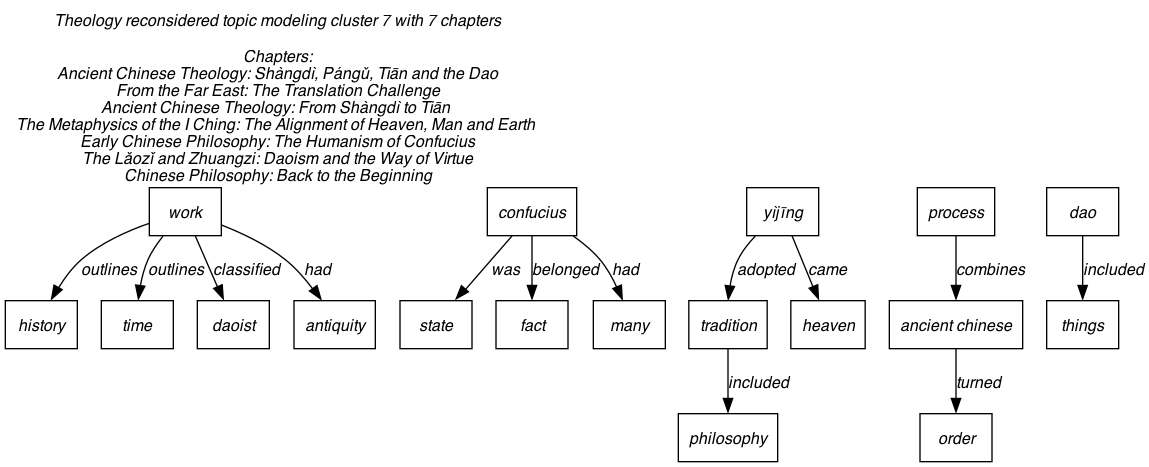

In [5]:
# Specify the chapters used in the analysis.
chosen_cluster = 7
use_key_terms = False

chosen_chapters = clusters[chosen_cluster]

chapter_titles = [titles[i] for i in chosen_chapters]
key_terms = key_terms_per_cluster[chosen_cluster]

print("Chosen chapters ", chosen_chapters)

# Specify the number of top words to use.
n = max(50, len(chosen_chapters)*5)

text_per_chapter = []
for chapter_idx in chosen_chapters:
    text_per_chapter.append(chapters[chapter_idx])

tf_idf_pre_filtering = get_word_types_with_tf_idf(
    text_per_chapter,
    "tf",
    skip_stopwords=True,
    include_verbs=False,
    include_determiners=False,
    include_pronouns=False,
    include_adverbs=False,
    include_numbers=False,
)

if use_key_terms:
    top_n_words = filter_topic_modeling_key_terms(
        key_terms=key_terms_per_cluster[chosen_cluster],
        tf_idf_word_types=tf_idf_pre_filtering,
        verbose=True,
    )
    
else:
    top_n_words = tf_idf_pre_filtering.head(n)["word"].values

# See difference between top words and key terms.
# print("Top words: ", top_n_words)
# print("Key terms: ", key_terms)
# print("Overlap: ", set(top_n_words).intersection(set(key_terms)))
# print("Symmetric difference: ", set(top_n_words).symmetric_difference(set(key_terms)))


# Create a list of all verses of the chosen books.
all_verses = []
for chapter_idx in chosen_chapters:
    all_verses.extend(sentences_per_chapter[chapter_idx])

# Extract the directed relations.
directed_relations, relations_to_verbs = get_directed_relations(
top_n_words=top_n_words,
all_verses=all_verses,
only_compounds=True,
verbose=True,
)

# Order the directed relations.
ordered_directed_relations = order_directed_relations(
    directed_relations=directed_relations,
    tf_idf_pre_filtering=tf_idf_pre_filtering,
    order_by="tf_idf",
    include_ordering_wrt_occurences=True,
    verbose=False,
)

# Construct the ontology hierarchy.
ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
    ordered_directed_relations=ordered_directed_relations,
)

# print_hierarchy_tree_from_ontology(
#     ontological_hierarchy=ontology_hierarchy,
#     words_with_parents=words_with_parents,
# )
draw_hierarchy_tree_from_ontology(
    ontological_hierarchy=ontology_hierarchy,
    relations_to_verbs=relations_to_verbs,
    title="Theology reconsidered topic modeling cluster " + str(chosen_cluster) + " with " + str(len(chosen_chapters)) + " chapters",
    topic_modelling_chapters=chapter_titles,
)


In [8]:
tf_idf_pre_filtering.head(n)

# print the row with word "cross"
tf_idf_pre_filtering[tf_idf_pre_filtering["word"] == "Daodejing"]

,word,word_type,tc,tf,dc,idf,tf_idf
0,chinese,"{'NNP': 97, 'GPE': 280, 'JJ': 193, 'NNPS': 7, ...",298,0.007432,7,0.000000,0.000000
1,ancient,"{'JJ': 171, 'NN': 29, 'NNP': 6, 'ORGANIZATION'...",209,0.005212,7,0.000000,0.000000
2,heaven,"{'NNP': 165, 'GPE': 68, 'NN': 19, 'PERSON': 49...",202,0.005038,7,0.000000,0.000000
4,philosophical,"{'JJ': 116, 'NN': 1}",158,0.003940,7,0.000000,0.000000
5,tradition,"{'NN': 119, 'VBP': 1}",121,0.003018,7,0.000000,0.000000
7,bce,"{'NNP': 96, 'ORGANIZATION': 52}",103,0.002569,7,0.000000,0.000000
8,world,"{'NN': 94, 'NNP': 6, 'PERSON': 4}",102,0.002544,7,0.000000,0.000000
9,ancient chinese,"{'VBN': 1, 'JJ': 364, 'NNPS': 7, 'GSP': 1, 'NN...",96,0.002394,7,0.000000,0.000000
12,earth,"{'NNP': 55, 'PERSON': 25, 'GPE': 29, 'NN': 30,...",91,0.002269,4,0.559616,0.001270
13,philosophy,"{'NN': 74, 'NNP': 4, 'PERSON': 2, 'GPE': 1}",89,0.002220,7,0.000000,0.000000


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc_1 = nlp(all_verses[196])
spacy.displacy.render(doc_1, style="dep", jupyter=True)

## Run for all clusters of the text

Removing the following terms:  ['also', 'well', 'one', 'first', 'writing', 'written', 'see', 'much', 'sumer', 'even', 'perhaps', 'sumer babylonian', 'find']


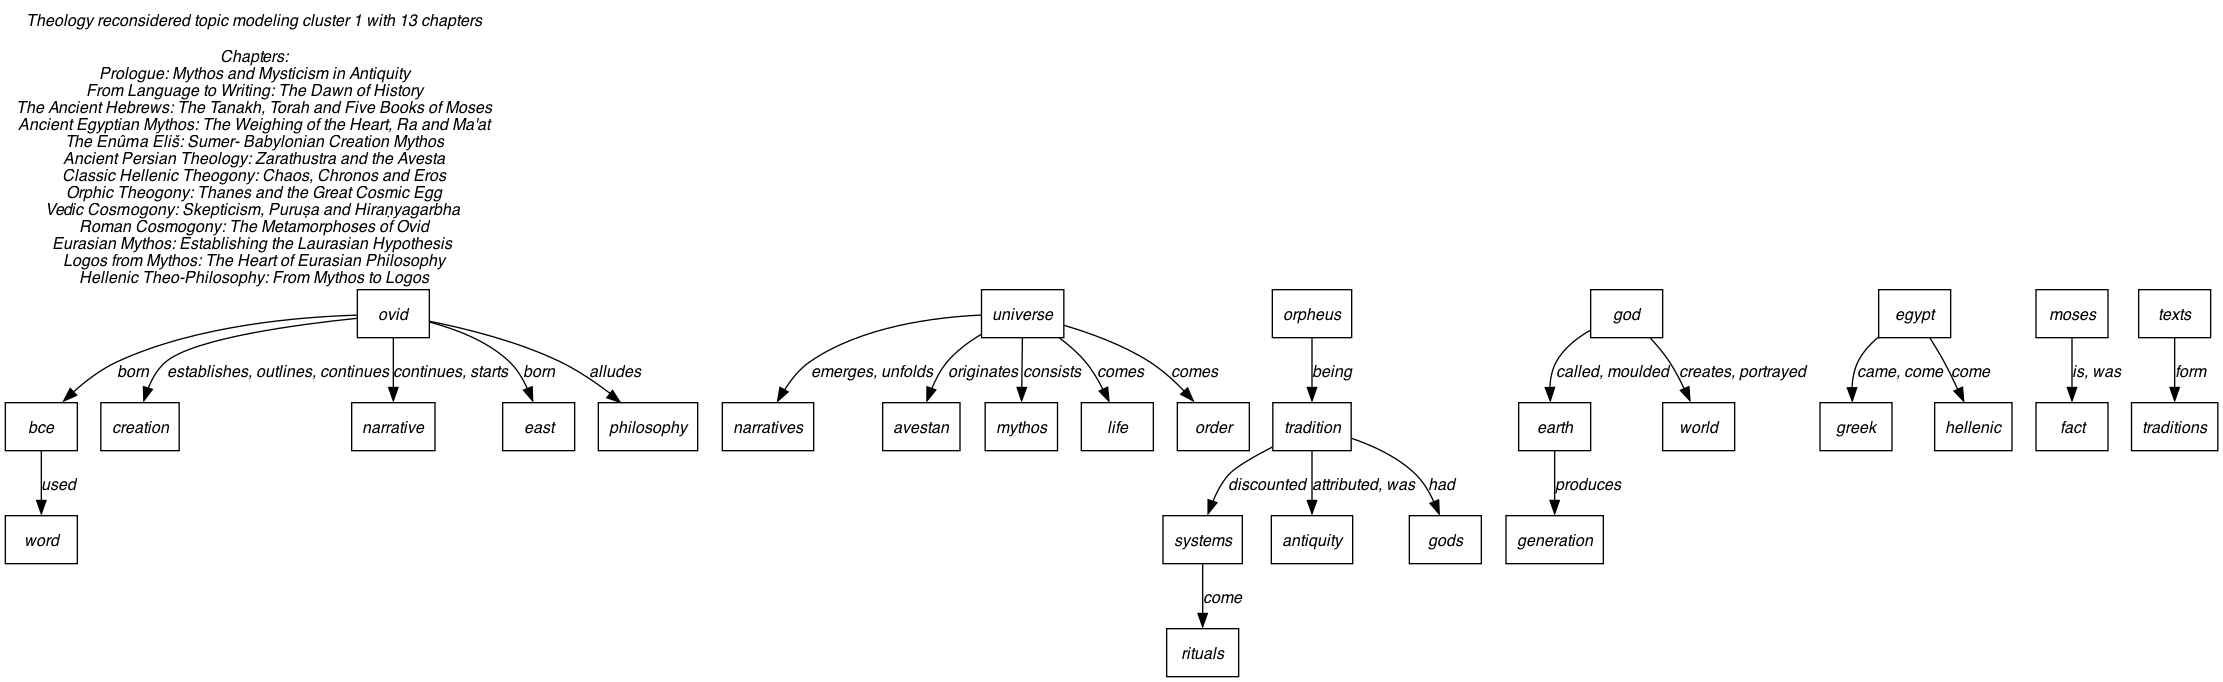

Removing the following terms:  ['subject object', 'metaphysics quality', 'static quality', 'object metaphysics', 'dynamic quality', 'one', 'even', 'subjectobject', 'motorcycle maintenance', 'subjects objects', 'aspect quality', 'subjectobject metaphysics', 'zen art', 'art motorcycle']


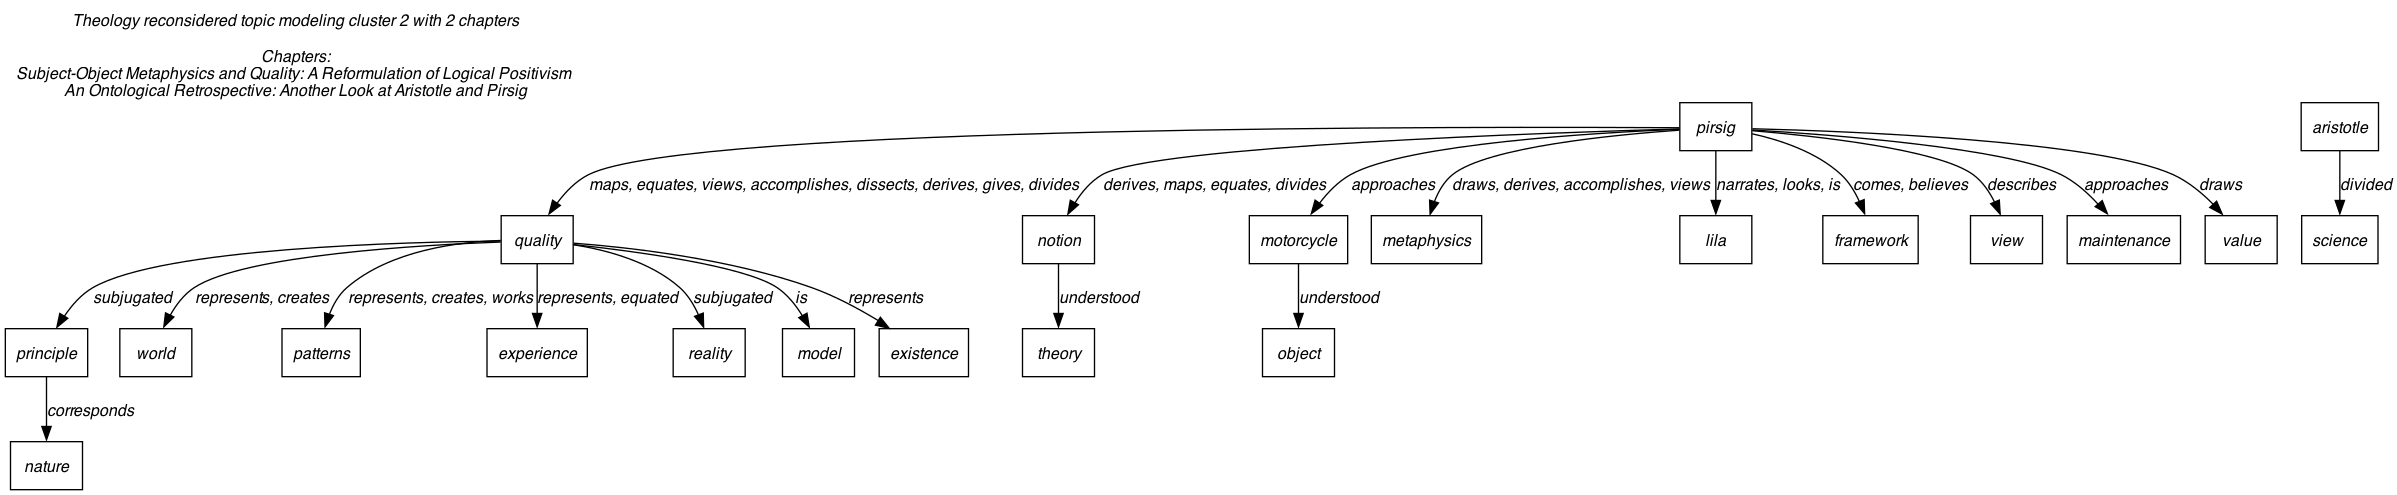

Removing the following terms:  ['suffering', 'one', 'also', 'well', 'first', 'works', 'form knowledge', 'said', 'know', 'two']


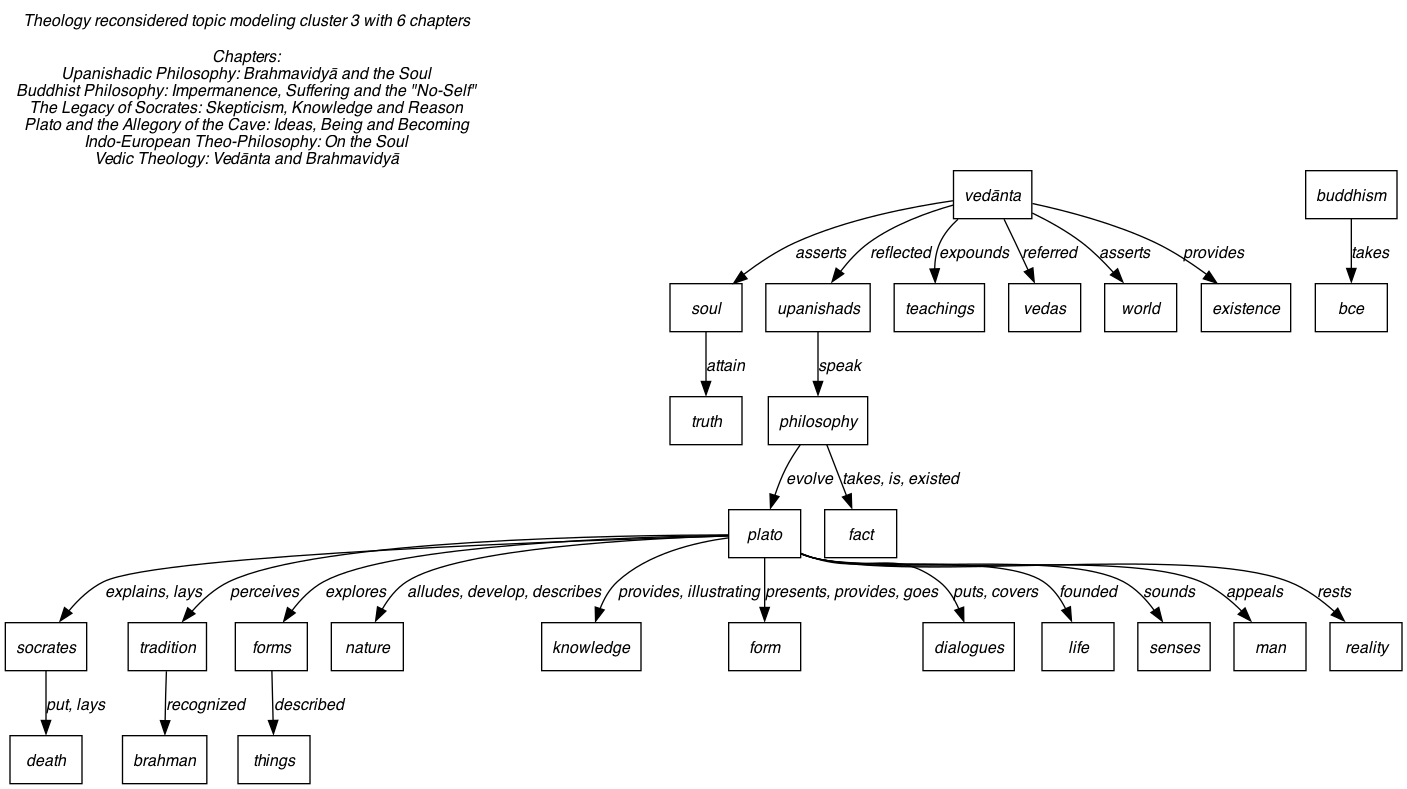

Removing the following terms:  ['well', 'theo', 'theo philosophical', 'also', 'one', 'find', 'even', 'first', 'much', 'theophilosophical', 'indo', 'throughout eurasia']


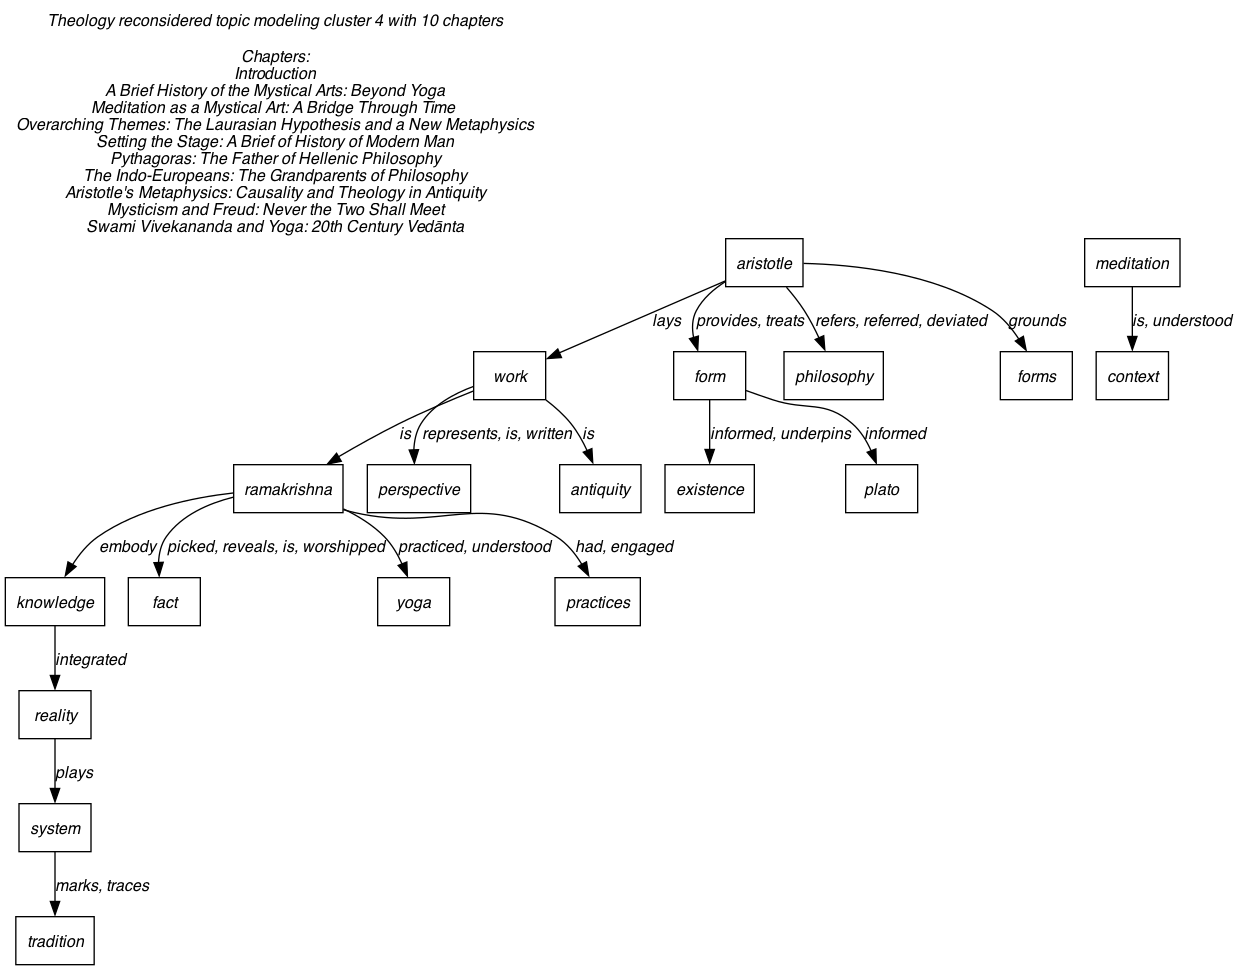

Removing the following terms:  ['quantum theory', 'quantum mechanics', 'classical mechanics', 'one', 'well', 'even', 'defined', 'underlying']


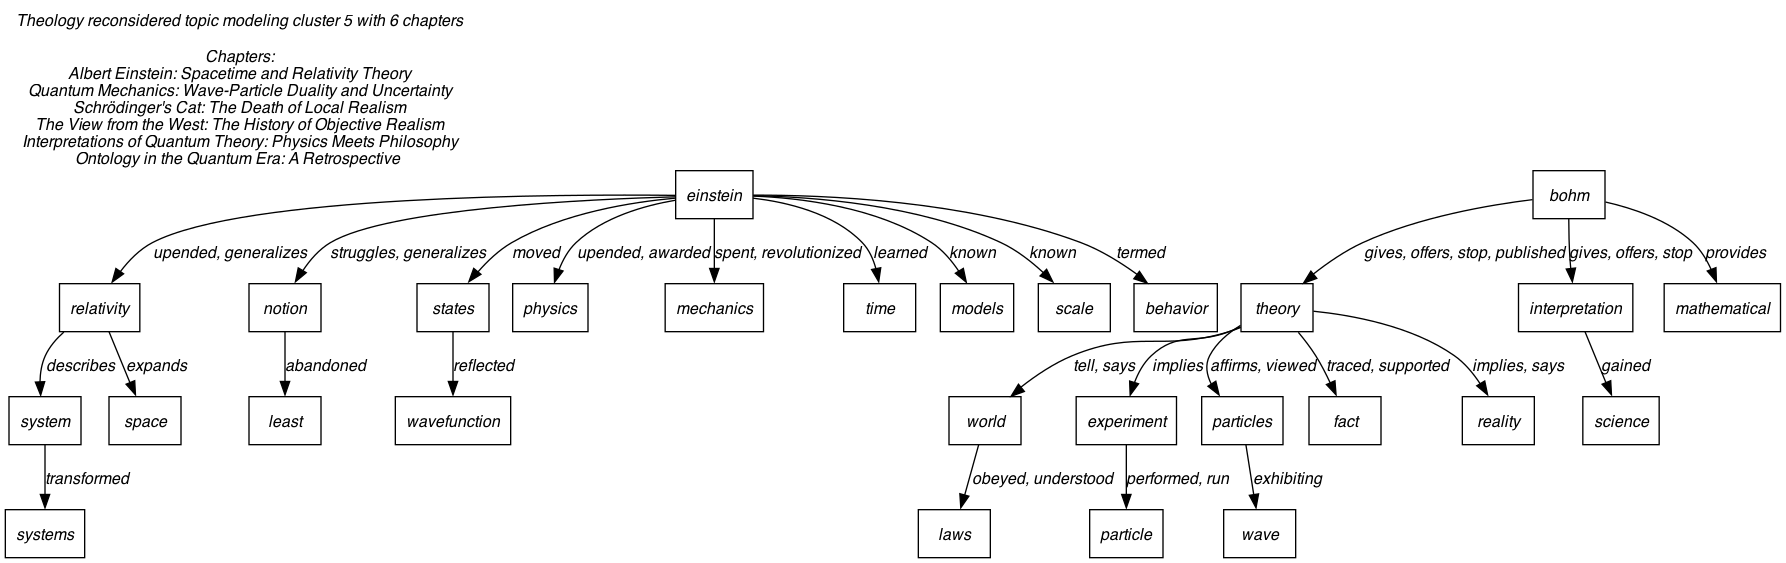

Removing the following terms:  ['one', 'well', 'also', 'metaphysics awareness']


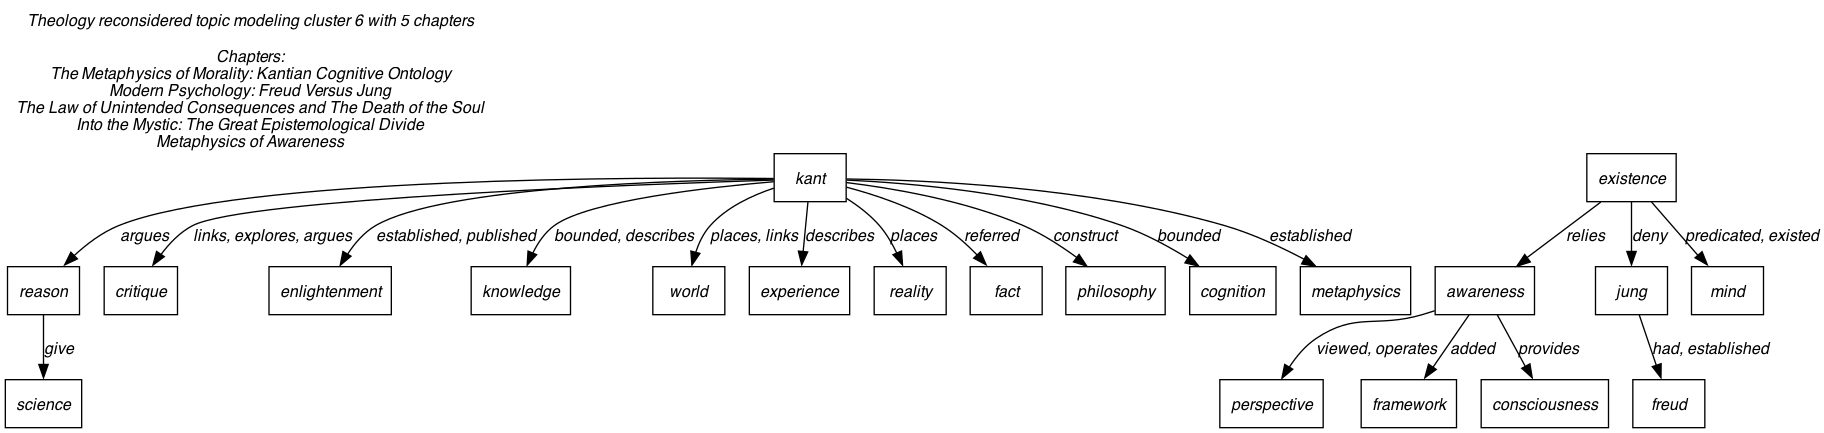

Removing the following terms:  ['one', 'ancient chinese', 'also', 'heaven earth', 'well', 'first', 'dàodé jīng', 'zhou dynasty', 'chinese antiquity', 'writing', 'see', 'form', 'chinese philosophical', 'two', 'even', 'written', 'eight']


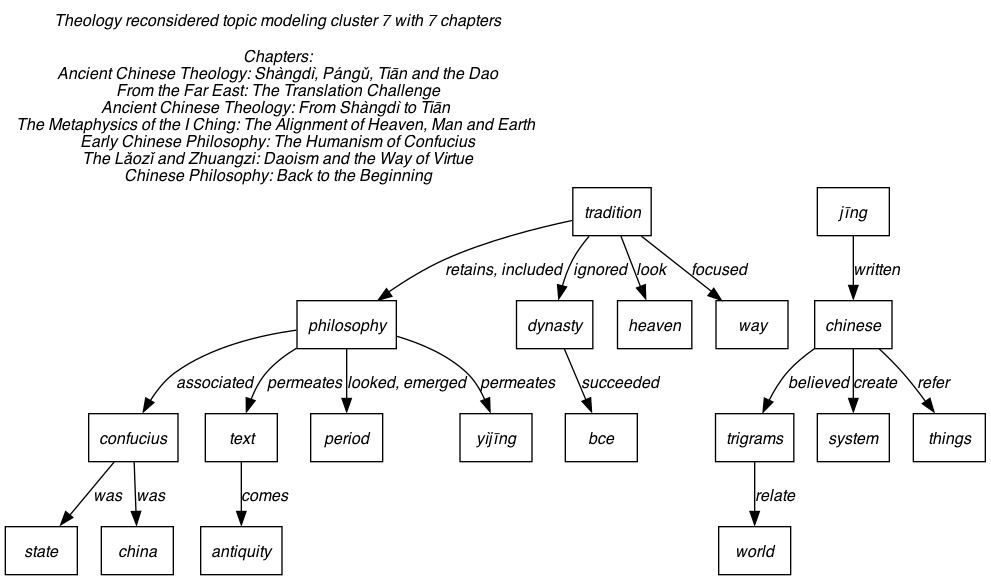

Removing the following terms:  ['al', 'one', 'also', 'well', 'first', 'works', 'muammad', 'salvation', 'old testament', 'qurn']


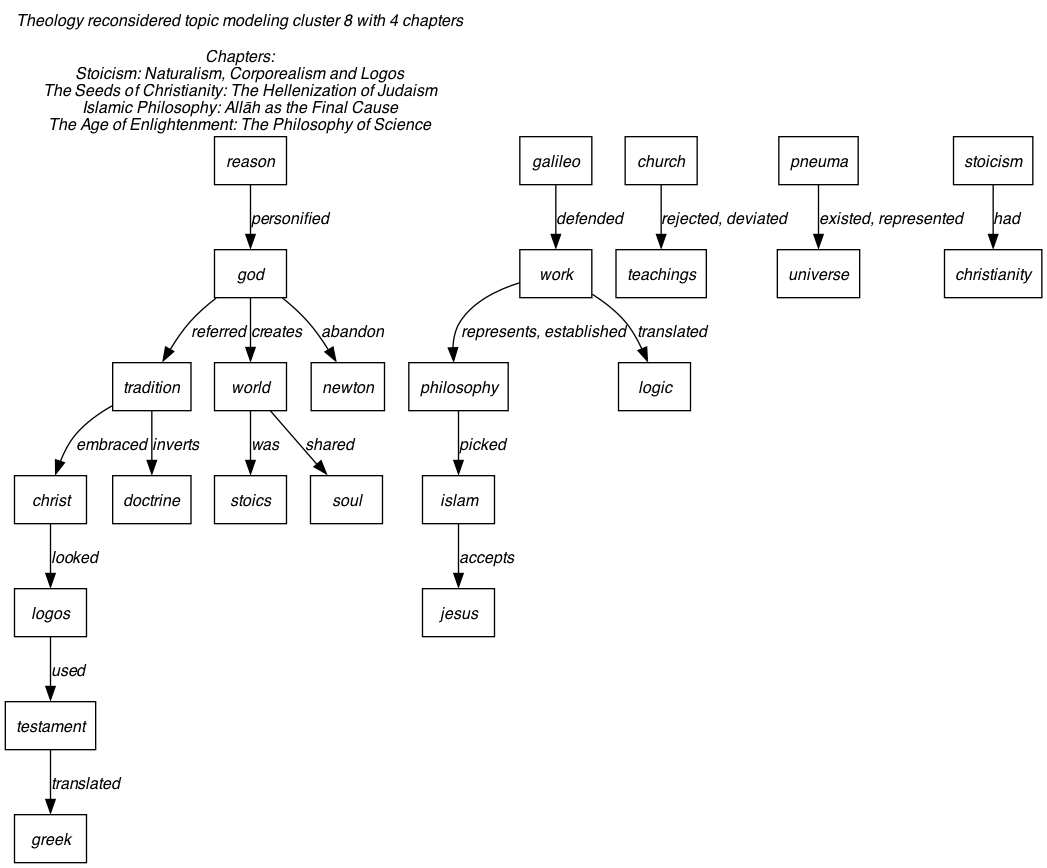

In [8]:
use_key_terms = True

# Specify the chapters used in the analysis.
for cluster in range(1, NUM_TOPICS+1):
    #print("Cluster: #", cluster)
    chosen_chapters = clusters[cluster]

    chapter_titles = [titles[i] for i in chosen_chapters]
    #print("Chosen chapters \n")
    # for title in chapter_titles:
    #     print(title)

    # Specify the number of top words to use.
    n = max(50, len(chosen_chapters)*5)

    text_per_chapter = []
    for chapter_idx in chosen_chapters:
        text_per_chapter.append(chapters[chapter_idx])

    tf_idf_pre_filtering = get_word_types_with_tf_idf(
        text_per_chapter,
        "tf",
        skip_stopwords=True,
        include_verbs=False,
        include_determiners=False,
        include_pronouns=False,
        include_adverbs=False,
        include_numbers=False,
    )

    if use_key_terms:
        top_n_words = top_n_words = filter_topic_modeling_key_terms(
            key_terms=key_terms_per_cluster[cluster],
            tf_idf_word_types=tf_idf_pre_filtering,
            verbose=True,
        )
    else:
        top_n_words = tf_idf_pre_filtering.head(n)["word"].values

    # Create a list of all verses of the chosen books.
    all_verses = []
    for chapter_idx in chosen_chapters:
        all_verses.extend(sentences_per_chapter[chapter_idx])
    directed_relations, relations_to_verbs = get_directed_relations(
        top_n_words=top_n_words,
        all_verses=all_verses,
        verbose=False,
    )
    ordered_directed_relations = order_directed_relations(
        directed_relations=directed_relations,
        tf_idf_pre_filtering=tf_idf_pre_filtering,
        order_by="product",
        include_ordering_wrt_occurences=True,
        verbose=False,
    )
    ontology_hierarchy, words_with_parents = construct_ontology_hierarchy(
        ordered_directed_relations=ordered_directed_relations,
    )
    # print_hierarchy_tree_from_ontology(
    #     ontological_hierarchy=ontology_hierarchy,
    #     words_with_parents=words_with_parents,
    # )
    draw_hierarchy_tree_from_ontology(
        ontological_hierarchy=ontology_hierarchy,
        relations_to_verbs=relations_to_verbs,
        title="Theology reconsidered topic modeling cluster " + str(cluster) + " with " + str(len(chosen_chapters)) + " chapters",
        topic_modelling_chapters=chapter_titles,
    )